In [2]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
    
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
        
def check_db():
    q = """SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table","view")"""
    return run_query(q)
    
    

In [3]:
check_db()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [4]:
q1="""
    WITH us_sales AS 
        (
        SELECT 
            il.*
            FROM invoice_line il
            INNER JOIN invoice i ON i.invoice_id=il.invoice_id
            INNER JOIN customer c ON c.customer_id=i.customer_id
            WHERE c.country == "USA"
        )
    
    SELECT
        g.genre_id,
        g.name genre,
        SUM(us.quantity) total_sold,
        cast(SUM(us.quantity) AS FLOAT)/
            (SELECT COUNT(*) FROM us_sales) percentage_sold
    FROM us_sales us
    INNER JOIN track t ON t.track_id=us.track_id
    INNER JOIN genre g ON g.genre_id=t.genre_id
    GROUP BY genre
    ORDER BY percentage_sold DESC
    """
sales_by_genre = run_query(q1)
sales_by_genre.set_index("genre", inplace=True, drop=True)
sales_by_genre


,genre_id,total_sold,percentage_sold
genre,,,
Rock,1,561,0.533777
Alternative & Punk,4,130,0.123692
Metal,3,124,0.117983
R&B/Soul,14,53,0.050428
Blues,6,36,0.034253
Alternative,23,35,0.033302
Latin,7,22,0.020932
Pop,9,22,0.020932
Hip Hop/Rap,17,20,0.019029


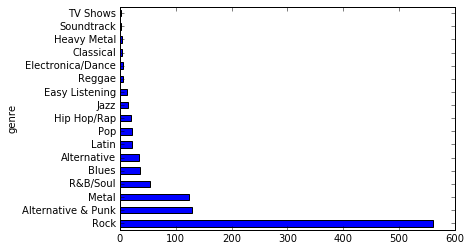

In [5]:

sales_by_genre["total_sold"].plot.barh()

Rock is a clear leader in sales. Based on these data, of the 4 genres of the potential new artists, most likely to succeed would be:
    Punk, Blues, Pop, and Hip Hop (in this order).
This suggest selecting the punk, Blues, and pop albums for distribution.


In [11]:

q2 = """

    SELECT
        e.first_name || " " || e.last_name name,
        SUM(i.total) total_sales,
        e.hire_date
    FROM employee e
    INNER JOIN customer c ON e.employee_id=c.support_rep_id
    INNER JOIN invoice i ON i.customer_id=c.customer_id
    GROUP BY 1    
    """
sales_reps = run_query(q2)
sales_reps.set_index("name", inplace=True, drop=True)


In [12]:
sales_reps

,total_sales,hire_date
name,,
Jane Peacock,1731.51,2017-04-01 00:00:00
Margaret Park,1584.00,2017-05-03 00:00:00
Steve Johnson,1393.92,2017-10-17 00:00:00


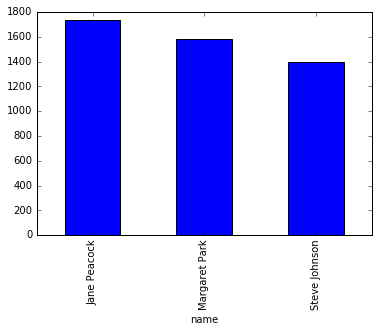

In [14]:
sales_reps["total_sales"].plot.bar()

The difference in sales between these sales reps seems to reflect their hire date

In [39]:
q3 = """
WITH country_plus_other AS
    (
    SELECT
        CASE
            WHEN (
                SELECT count (*) FROM customer
                WHERE country = c.country
                 )
                =1 THEN "Other"
            ELSE c.country
        END AS country,
        c.customer_id,
        il.*
    FROM customer c
    INNER JOIN invoice i ON i.customer_id=c.customer_id
    INNER JOIN invoice_line il ON il.invoice_id=i.invoice_id
    )

SELECT 
    cpo.country,
    COUNT(DISTINCT cpo.customer_id) total_customers,
    SUM(i.total) total_value_of_sales,
    SUM(i.total)/
        SUM(cpo.customer_id) value_per_customer,
    CASE
        WHEN cpo.country = "Other"
        THEN 1
        ELSE 0
    END AS sort
FROM country_plus_other cpo
LEFT JOIN invoice i ON i.customer_id=cpo.customer_id
GROUP BY 1
ORDER BY sort ASC, total_value_of_sales DESC
"""

run_query(q3)


,country,total_customers,total_value_of_sales,value_per_customer,sort
0,USA,13,86035.95,0.364115,0
1,Canada,8,40115.79,0.317465,0
2,Brazil,5,38881.26,0.802238,0
3,Czech Republic,2,37833.84,1.681504,0
4,France,5,31314.69,0.191890,0
5,Germany,4,28498.14,0.295808,0
6,United Kingdom,3,20752.38,0.165620,0
7,India,2,17773.47,0.149124,0
8,Portugal,2,17527.95,0.189598,0
9,Other,15,87003.18,0.184868,1
